# Algoritmo de Entrenamiento

#### Pseudocódigo

1. **Pre-tokenizar el corpus en palabras.**

2. **Generar el alfabeto como las letras de cada palabra , N = (iniciales + ##resto de letras).**
    - Ejemplo: 
        - "Tomate" -> `T ##o ##m ##a ##t ##e`

3. **Añadir los tokens especiales:**
    - `"[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"`

4. **Crear un diccionario de divisiones por palabra.**
    - Ejemplo: 
        ```json
        {
            "hola": ['h', '##o', '##l', '##a'],
            "como": ['c', '##o', '##m', '##o'],
            "estas": ['e', '##s', '##t', '##a', '##s']
        }
        ```

#### Repetir hasta k mezclas:

5. **Calcular todos los pares existentes en el diccionario de divisiones por palabra y su score.**  
    - `score = (frecuencia_del_par) / (frecuencia_del_primer_elemento × frecuencia_del_segundo_elemento)`
    - Ejemplos de pares:
        - ('h', '##o')
        - ('##o', '##l')
        - ('##l', '##a')
        - ('c', '##o')
        - ('##o', '##m')
        - ('##a', '##s')

6. **Seleccionar el par con mayor score.**

7. **Agregar este par al vocabulario.**

8. **Mezclar en el diccionario de divisiones.**

#### Final:
- Al finalizar, obtendremos un nuevo vocabulario con `N + k` tokens.


In [13]:
# 1. Tokenizamos el corpues en palabras
import re

def pre_tokenize(text):
    # Devuelve una lista de palabras en minúsculas, con signos de puntacion.
    return re.findall(r'\b\w+\b|[,.]', text.lower())

In [14]:
texto = "Hola, ¿cómo estás? Este es un texto de prueba 1."
print(pre_tokenize(texto))

['hola', ',', 'cómo', 'estás', 'este', 'es', 'un', 'texto', 'de', 'prueba', '1', '.']


In [34]:
corpus = "Hola soy gabo."
pre_tokenized_corpus = pre_tokenize(corpus)
# 2. Creamos el vocabulario inicial
def start_vocab():
        vocab = []
        # Recorremos cada palabra del corpus (pre-tokenizado)
        for word in pre_tokenized_corpus:
            # La letra inicial se agrega al vocabulario
            if word[0] not in vocab:
                vocab.append(word[0])
            # Todas las demas letras se  le añade '##' al vocabulario
            for letter in word[1:]:
                if letter not in vocab:
                    vocab.append('##' + letter)
        # 3.Agregamos los tokens especiales
        # "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"
        tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
        for token in tokens:
            vocab.append(token)
        return vocab

print(start_vocab())

['h', '##o', '##l', '##a', 's', '##o', '##y', 'g', '##a', '##b', '##o', '.', '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']


In [37]:
corpus = "Hola soy gabo."
pre_tokenized_corpus = pre_tokenize(corpus)
# 4 . Creamos el diccionario de divisiones
divisions = {
    palabra: [ c if i==0 else f'##{c}' for i, c in enumerate(palabra) ]
            # 1. Para cada palabra en el corpus pre-tokenizado
            for palabra in pre_tokenized_corpus
}
print(divisions)

{'hola': ['h', '##o', '##l', '##a'], 'soy': ['s', '##o', '##y'], 'gabo': ['g', '##a', '##b', '##o'], '.': ['.']}


In [38]:
# 5. Calculamos todas las frecuencias de cada palabra
corpus = "Hola soy gabo."
pre_tokenized_corpus = pre_tokenize(corpus)

def word_frequencies(corpus):
    # Inicializamos un diccionario vacio
    freqs = {}
    # Recorremos cada palabra en el corpus
    for word in corpus:
        # Si la palabra no esta en el diccionario, la inicializamos en 0
        if word not in freqs:
            freqs[word] = 0
        # Aumentamos la frecuencia de la palabra en 1
        freqs[word] += 1
    return freqs

print(word_frequencies(pre_tokenized_corpus))


{'hola': 1, 'soy': 1, 'gabo': 1, '.': 1}


In [40]:
from collections import defaultdict

# Ejemplo de un default dict
d = defaultdict(int)
print(d)  # defaultdict(<class 'int'>, {})
print(d['hola'])  # 0


defaultdict(<class 'int'>, {})
0


In [41]:
corpus = "Hola soy gabo."
pre_tokenized_corpus = pre_tokenize(corpus)
frecuencias_palabras = word_frequencies(pre_tokenized_corpus)

# Inicializamos un diccionario vacio
letter_freqs = defaultdict(int)
# inicializamos un pair frequency
pair_freqs = defaultdict(int)

# Recorremos todas las palabras del corpus
for word,freq in frecuencias_palabras.items():
    # Almacenamos el split o tokenizacion en divisiones de la palabra
    word_divisions = divisions[word]

    if len(word_divisions) == 1:
        # Si solo hay una division, aumentamos la frecuencia de la letra
        letter_freqs[word_divisions[0]] += freq
        continue

    # Si hay mas de una division, recorremos cada par de divisiones
    for i in range(len(word_divisions) - 1):
        # Alamacenamos el par
        par = (word_divisions[i], word_divisions[i + 1])
        # Aumentamos la frecuencia del par
        pair_freqs[par] += freq
        # Aumentamos la frecuencia de la letra
        letter_freqs[word_divisions[i]] += freq
    # Aumentamos la frecuencia de la ultima letra
    letter_freqs[word_divisions[-1]] += freq

    # Calculamos el score
    scores = {
        pair: freq/ (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair,freq in pair_freqs.items()
    }

scores

{('h', '##o'): 0.3333333333333333,
 ('##o', '##l'): 0.3333333333333333,
 ('##l', '##a'): 0.5,
 ('s', '##o'): 0.3333333333333333,
 ('##o', '##y'): 0.3333333333333333,
 ('g', '##a'): 0.5,
 ('##a', '##b'): 0.5,
 ('##b', '##o'): 0.3333333333333333}

In [42]:
# Calculando el mejor score
best_pair = ""
max_score = None
for pair, score in scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('##l', '##a') 0.5


In [77]:
def merge_pair(a, b, splits):
    for word in frecuencias_palabras:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

merge_pair('##l','##a', divisions)

{'hola': ['h', '##o', '##la'],
 'soy': ['s', '##o', '##y'],
 'gabo': ['g', '##a', '##b', '##o'],
 '.': ['.']}

In [130]:
from collections import defaultdict
import re

class WorPiece:
    def __init__(self, corpus: str, k: int = 40, verbose: bool = False):
        # iniciamos el corpus
        self.corpus = corpus
        # pre-tokenizamos el corpus
        self.pre_tokenized_corpus = self.pre_tokenize(corpus)
        # creamos el vocabulario inicial
        self.vocab = self.start_vocab()
        # Creamos un diccionario de divisiones por palabra
        self.word_pieces = self.start_word_pieces()

        # Numero de mezclas
        self.k = k
        # Calculamos las frecuencias de cada palabra
        self.pre_word_freq = self.get_pre_word_freq()

        # Modo verbose para imprimir los pasos
        self.verbose = verbose
    
    def get_pre_word_freq(self):
        word_freq = {}
        for word in self.pre_tokenized_corpus:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
        return word_freq

    def start_word_pieces(self):
        word_pieces = {
            # 2. Para cada palabra en el corpus pre-tokenizado
            palabra: [ c if i == 0 else f'##{c}' for i, c in enumerate(palabra) ]
            # 1. Para cada palabra en el corpus pre-tokenizado
            for palabra in self.pre_tokenized_corpus
        }
        return word_pieces
    
    def start_vocab(self):
        vocab = []
        # Recorremos cada palabra del corpus (pre-tokenizado)
        for word in self.pre_tokenized_corpus:
            # La letra inicial se agrega al vocabulario
            if word[0] not in vocab:
                vocab.append(word[0])
            # Todas las demás letras se les añade '##' al vocabulario
            for letter in word[1:]:
                if '##' + letter not in vocab:
                    vocab.append('##' + letter)
        
        # Agregamos los tokens especiales
        tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
        for token in tokens:
            vocab.append(token)

        return vocab
             
    def pre_tokenize(self, text):
        return re.findall(r'\b\w+\b|[,.]', text.lower())
    
    # Función para calcular los puntajes de los pares
    def compute_pair_scores(self):
        letter_freqs = defaultdict(int)
        pair_freqs = defaultdict(int)
        
        # Calcular frecuencias de letras y pares
        for word, freq in self.pre_word_freq.items():
            split = self.word_pieces[word]
            if len(split) == 1:
                letter_freqs[split[0]] += freq
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                letter_freqs[split[i]] += freq
                pair_freqs[pair] += freq
            letter_freqs[split[-1]] += freq

        # Calcular puntajes de los pares
        scores = {
            pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
            for pair, freq in pair_freqs.items()
        }
        return scores
    
    # Función para hacer la mezcla del par seleccionado
    def merge_pair(self, a, b, splits):
        # Recorrer cada palabra en el corpus
        for word in self.pre_word_freq:
            # Obtener la división de la palabra
            split = splits[word]
            # Si la palabra tiene solo una división, continuar
            if len(split) == 1:
                continue
            # Recorrer cada par de divisiones
            i = 0
            while i < len(split) - 1:
                # Si el par actual es igual al par seleccionado
                if split[i] == a and split[i + 1] == b:
                    # Realizar la mezcla
                    merge = a + b[2:] if b.startswith("##") else a + b
                    # Actualizar la división de la palabra
                    split = split[:i] + [merge] + split[i + 2:]                    
                else:
                    # Incrementar el índice
                    i += 1
            # Actualizar la división de la palabra
            splits[word] = split
        
        return splits

    # Paso de entrenamiento: seleccionar el mejor par y actualizar las divisiones de palabra
    def train(self):
        # Iterar sobre el número de mezclas
        for i in range(self.k):
            if self.verbose:
                print(f"\n=== Iteración {i + 1} ===")
                print("Vocabulario actual:", self.vocab)
                print("Divisiones actuales (word_pieces):", self.word_pieces)

            # Calcular los puntajes de los pares
            scores = self.compute_pair_scores()
            if self.verbose:
                print("Puntajes calculados:", scores)

            if scores == {}:
                if self.verbose:
                    print("No hay más pares para procesar. Finalizando entrenamiento.")
                break

            # Seleccionar el par con el puntaje más alto
            best_pair = max(scores, key=scores.get)
            if self.verbose:
                print(f"Mejor par seleccionado: {best_pair} con puntaje: {scores[best_pair]}")

            # Actualizar las divisiones de palabra
            self.word_pieces = self.merge_pair(best_pair[0], best_pair[1], self.word_pieces)
            if self.verbose:
                print("Nuevas divisiones (word_pieces):", self.word_pieces)

            # Agregar el nuevo token al vocabulario
            new_token = best_pair[0] + best_pair[1][2:] if best_pair[1].startswith("##") else best_pair[0] + best_pair[1]
            self.vocab.append(new_token)
            if self.verbose:
                print(f"Nuevo token añadido al vocabulario: {new_token}")

    def tokenize(self, word):
        tokens = []
        while len(word) > 0:
            i = len(word)
            while i > 0 and word[:i] not in self.vocab:
                i -= 1
            if i == 0:
                return ["[UNK]"]
            tokens.append(word[:i])
            word = word[i:]
            if len(word) > 0:
                word = f"##{word}"
        return tokens

    def tokenize_WordPiece(self, text):
        words = self.pre_tokenize(text)
        encoded_words = [self.tokenize(word) for word in words] 

        return sum(encoded_words, [])


In [135]:
corpus = '''prueba de tokens
'''
wp = WorPiece(corpus,verbose=True)
print(wp.vocab)

['p', '##r', '##u', '##e', '##b', '##a', 'd', 't', '##o', '##k', '##n', '##s', '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']


In [136]:
print(wp.word_pieces)

{'prueba': ['p', '##r', '##u', '##e', '##b', '##a'], 'de': ['d', '##e'], 'tokens': ['t', '##o', '##k', '##e', '##n', '##s']}


In [137]:
print(wp.pre_word_freq)

{'prueba': 1, 'de': 1, 'tokens': 1}


In [138]:
print(wp.compute_pair_scores())

{('p', '##r'): 1.0, ('##r', '##u'): 1.0, ('##u', '##e'): 0.3333333333333333, ('##e', '##b'): 0.3333333333333333, ('##b', '##a'): 1.0, ('d', '##e'): 0.3333333333333333, ('t', '##o'): 1.0, ('##o', '##k'): 1.0, ('##k', '##e'): 0.3333333333333333, ('##e', '##n'): 0.3333333333333333, ('##n', '##s'): 1.0}


In [139]:
wp.train()


=== Iteración 1 ===
Vocabulario actual: ['p', '##r', '##u', '##e', '##b', '##a', 'd', 't', '##o', '##k', '##n', '##s', '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
Divisiones actuales (word_pieces): {'prueba': ['p', '##r', '##u', '##e', '##b', '##a'], 'de': ['d', '##e'], 'tokens': ['t', '##o', '##k', '##e', '##n', '##s']}
Puntajes calculados: {('p', '##r'): 1.0, ('##r', '##u'): 1.0, ('##u', '##e'): 0.3333333333333333, ('##e', '##b'): 0.3333333333333333, ('##b', '##a'): 1.0, ('d', '##e'): 0.3333333333333333, ('t', '##o'): 1.0, ('##o', '##k'): 1.0, ('##k', '##e'): 0.3333333333333333, ('##e', '##n'): 0.3333333333333333, ('##n', '##s'): 1.0}
Mejor par seleccionado: ('p', '##r') con puntaje: 1.0
Nuevas divisiones (word_pieces): {'prueba': ['pr', '##u', '##e', '##b', '##a'], 'de': ['d', '##e'], 'tokens': ['t', '##o', '##k', '##e', '##n', '##s']}
Nuevo token añadido al vocabulario: pr

=== Iteración 2 ===
Vocabulario actual: ['p', '##r', '##u', '##e', '##b', '##a', 'd', 't', '##o', '##k', '

In [140]:
wp.vocab

['p',
 '##r',
 '##u',
 '##e',
 '##b',
 '##a',
 'd',
 't',
 '##o',
 '##k',
 '##n',
 '##s',
 '[PAD]',
 '[UNK]',
 '[CLS]',
 '[SEP]',
 '[MASK]',
 'pr',
 'pru',
 '##ba',
 'to',
 'tok',
 '##ns',
 'prue',
 'prueba',
 'de',
 'toke',
 'tokens']

In [141]:
vocab = wp.vocab

# Algoritmo de Tokenización

1. **Pre-tokenizamos el texto en palabras.**
    - Para cada palabra:
        -  `new_palabra` <- palabra
        - Mientras exista `new_palabra` :
            1. Buscamos en `new_palabra` la subpalabra más larga contenida en el vocabulario, empezando desde el inicio.
                  1. **Si la subpalabra se encuentra en el vocabulario:**
                      - La añadimos a una lista de tokens.
                      - Actualizamos `new_palabra` con la parte restante de la palabra, precedida por "`##`".
                  2. **Si no se encuentra la subpalabra en el vocabulario:**
                      - Devolvemos el token especial `[UNK]` (para palabras desconocidas).

        - **Retornar la palabra tokenizada.**

2. Retornamos las palabras tokenizadas
             
        

In [142]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [143]:
word = 'prueba'
encode_word(word)

['prueba']

In [144]:
wp = WorPiece(corpus)
wp.train()
print(wp.tokenize_WordPiece('pruebas de otro ejemplo'))

['prueba', '##s', 'de', '[UNK]', '[UNK]']


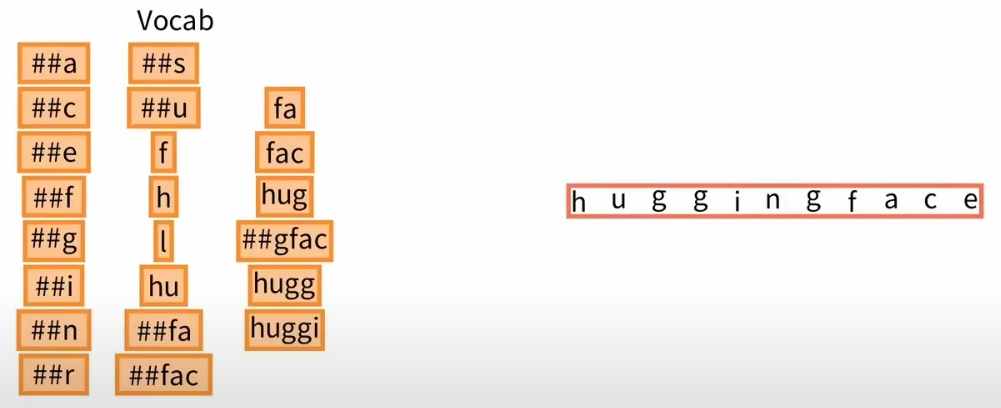
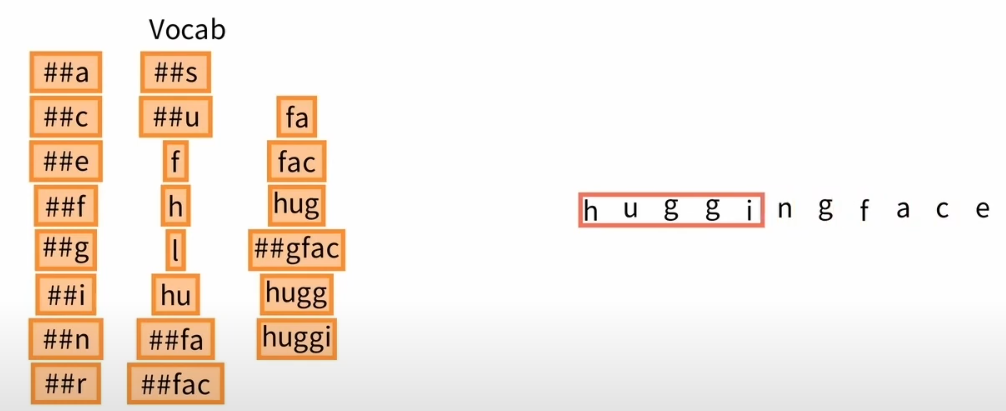
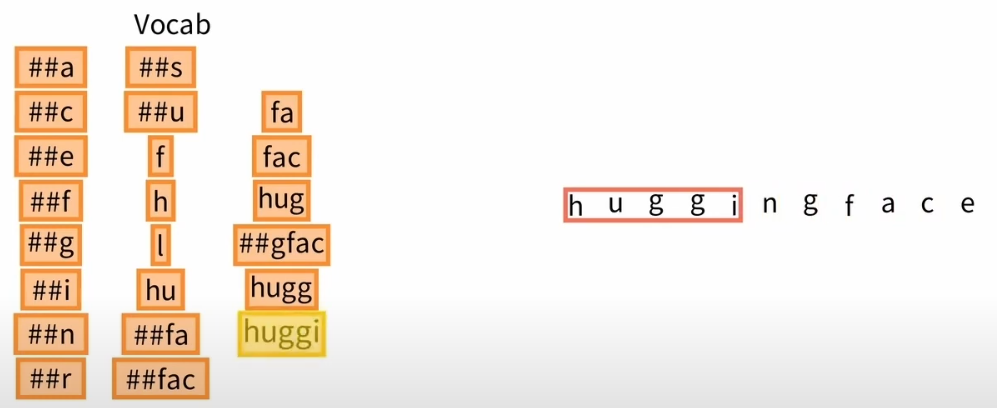
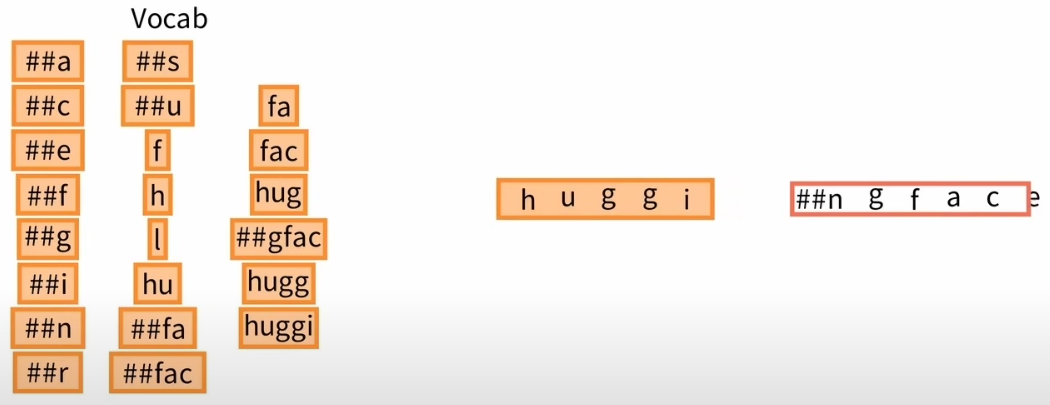
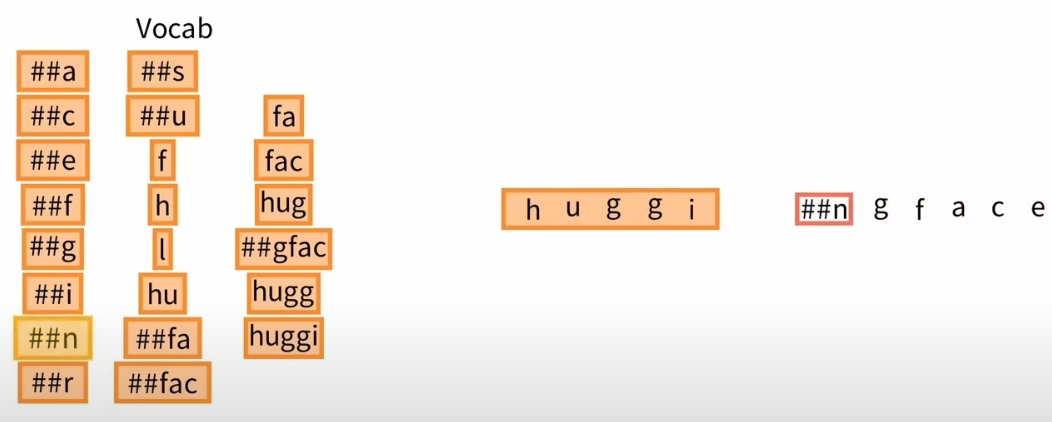
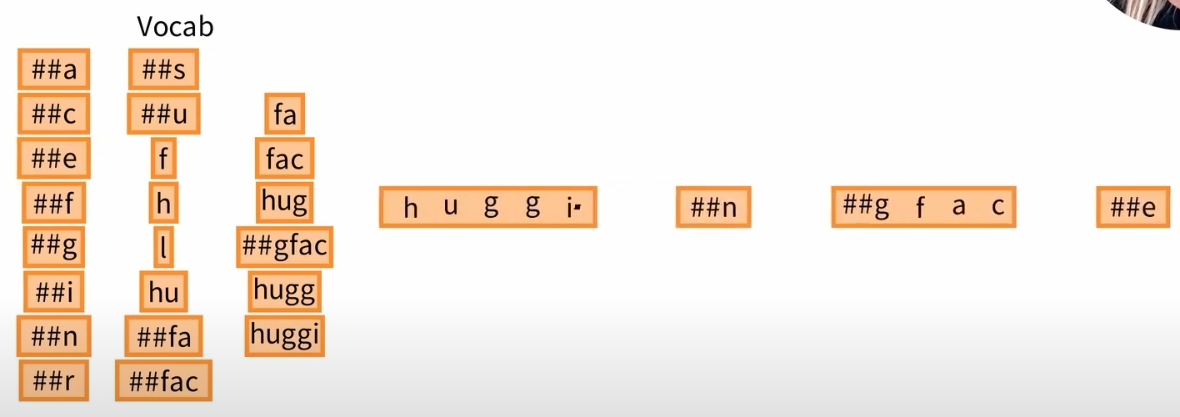